In [1]:
import torch
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import transforms, datasets
from typing import *

sns.set_style("whitegrid")

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


## Loading Data

### About the dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

The classes are:

| Label |	Description |
|-------|-------------|
| 0     |	airplane    |
| 1     |	automobile  |
| 2     |	bird        |
| 3     |	cat         |
| 4     |	deer        |
| 5     |	dog         |
| 6     |	frog        |
| 7     |	horse       |
| 8     |	ship        |
| 9     |	truck       |

Source: https://www.cs.toronto.edu/~kriz/cifar.html

In [2]:
train = datasets.CIFAR10(
    "cifar10",
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
    ]),
    target_transform=transforms.Lambda(lambda x: torch.nn.functional.one_hot(torch.tensor(x).long(), num_classes=10).float()),
    download=True
)

test  = datasets.CIFAR10("cifar10",
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
    ]),
    target_transform=transforms.Lambda(lambda x: torch.nn.functional.one_hot(torch.tensor(x).long(), num_classes=10).float()),
    download=True)

trainloader = torch.utils.data.DataLoader(train, batch_size=64,  shuffle=True)
testloader  = torch.utils.data.DataLoader(test,  batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Helper Functions

In [3]:
def train_model(model, trainloader, epoch: int = 5, lr: float | Callable[[int], float] = 0.001):
    model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters())

    model.train()

    losses = []

    for e in range(epoch):
        running_loss = 0
        optimizer.param_groups[0]['lr'] = lr if isinstance(lr, float) else lr(e)
        for batch, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(images)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        losses.append(running_loss / (batch + 1))
    return losses

def eval_model(model, testloader):
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()

    test_loss = 0
    accuracy  = 0

    model.eval()

    with torch.no_grad():
        for batch, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            loss = criterion(pred, labels)
            test_loss += loss.item()
            accuracy  += (pred.argmax(dim=1) == labels.argmax(dim=1)).sum().item()

    test_loss /= batch + 1
    accuracy  /= testloader.batch_size * (batch + 1)

    return test_loss, accuracy


## Model Training and Evaluation


We will train different neural network models with different activation functions, hidden layers, and learning rates.

### Learning Rate tuning


In [4]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(32 * 32 * 3, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 10),
    torch.nn.Softmax(dim=1)
)


lr_results = {}

lr_grid = {
    "10^-3": 0.001,
    "10^-2": 0.01,
    "10^-1": 0.1,
    "lr_lambda": lambda epoch: 0.1 * (1/1+0.01*epoch)
}

for k, lr in lr_grid.items():
    losses = train_model(model, trainloader, epoch=15, lr=lr)
    test_loss, accuracy = eval_model(model, testloader)
    lr_results[k] = (losses, test_loss, accuracy)

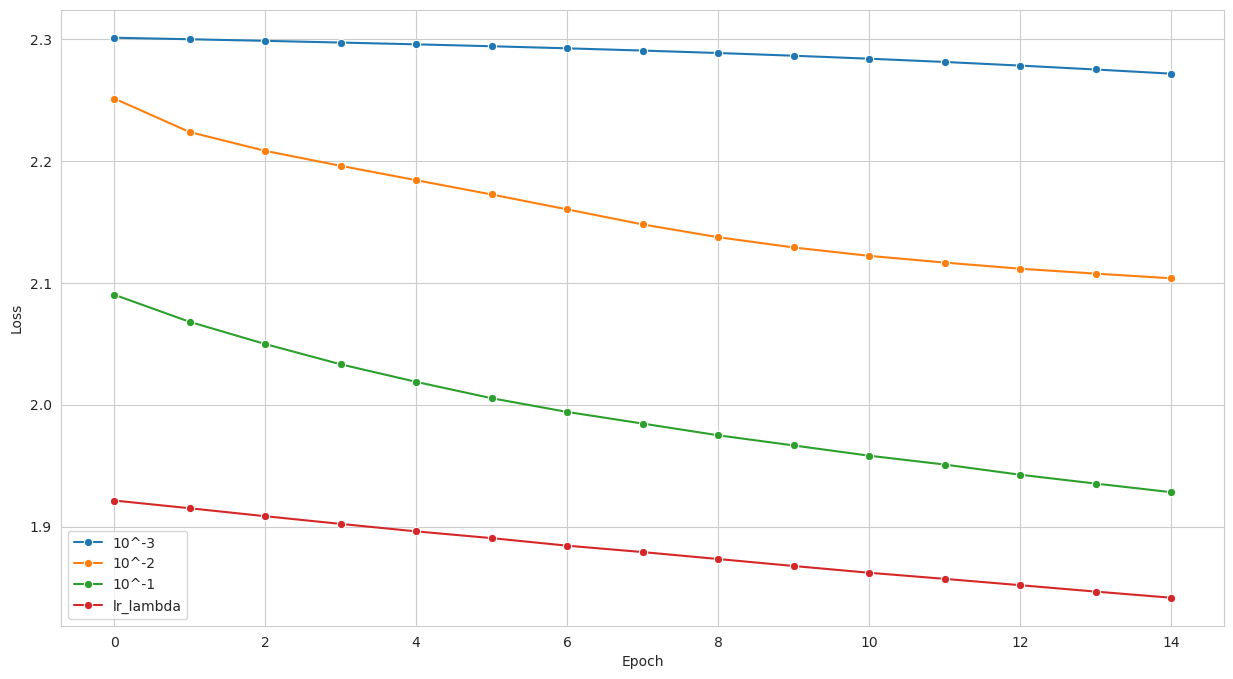

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

for k, (losses, test_loss, accuracy) in lr_results.items():
    sns.lineplot(losses, label=k, ax=ax, marker='o')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.show()

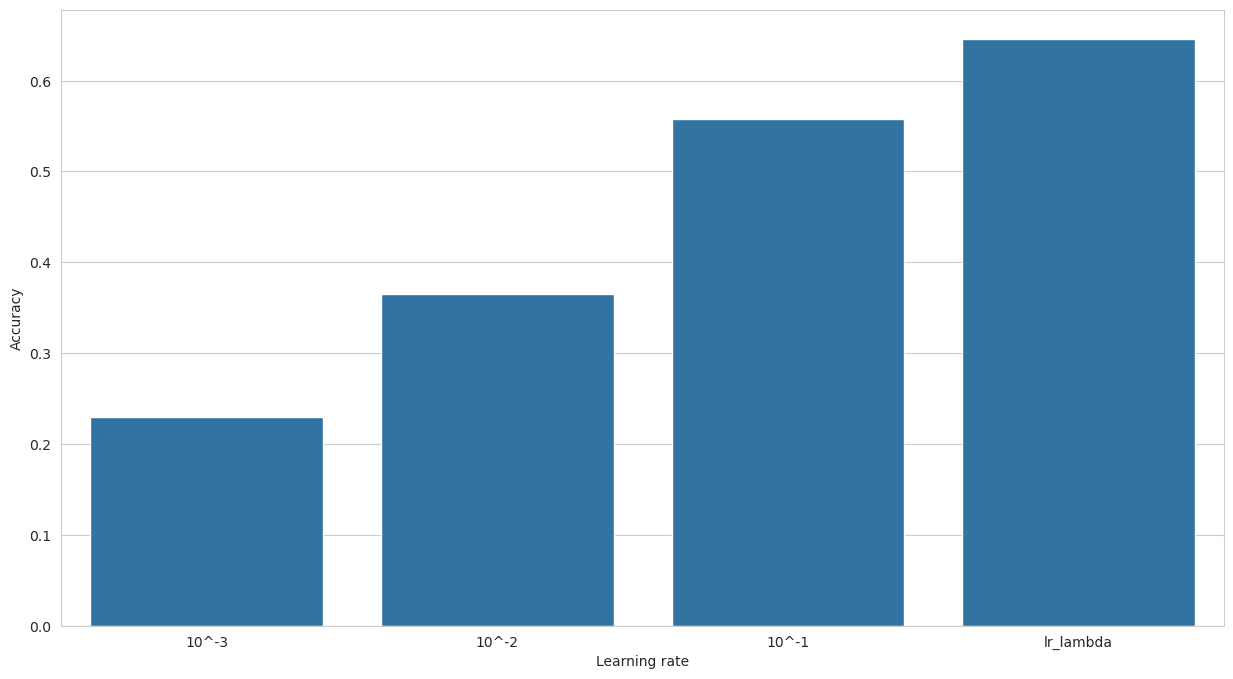

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

ks = []
vs = []

for k, (losses, test_loss, accuracy) in lr_results.items():
    ks += [k]
    vs += [accuracy]
    
sns.barplot(x=ks, y=vs, ax=ax)

ax.set_xlabel("Learning rate")
ax.set_ylabel("Accuracy")

plt.show()

### Activation Function tuning

In [6]:
af_grid = {
    "ReLU": torch.nn.ReLU(),
    "Sigmoid": torch.nn.Sigmoid(),
    "Tanh": torch.nn.Tanh(),
    "GELU": torch.nn.GELU(),
}

af_results = {}

for k, af in af_grid.items():
    model = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(32 * 32 * 3, 512),
        af,
        torch.nn.Linear(512, 10),
        torch.nn.Softmax(dim=1)
    )
    losses = train_model(model, trainloader, epoch=15, lr=lambda epoch: 0.1 * (1/1+0.01*epoch))
    test_loss, accuracy = eval_model(model, testloader)
    af_results[k] = (losses, test_loss, accuracy)

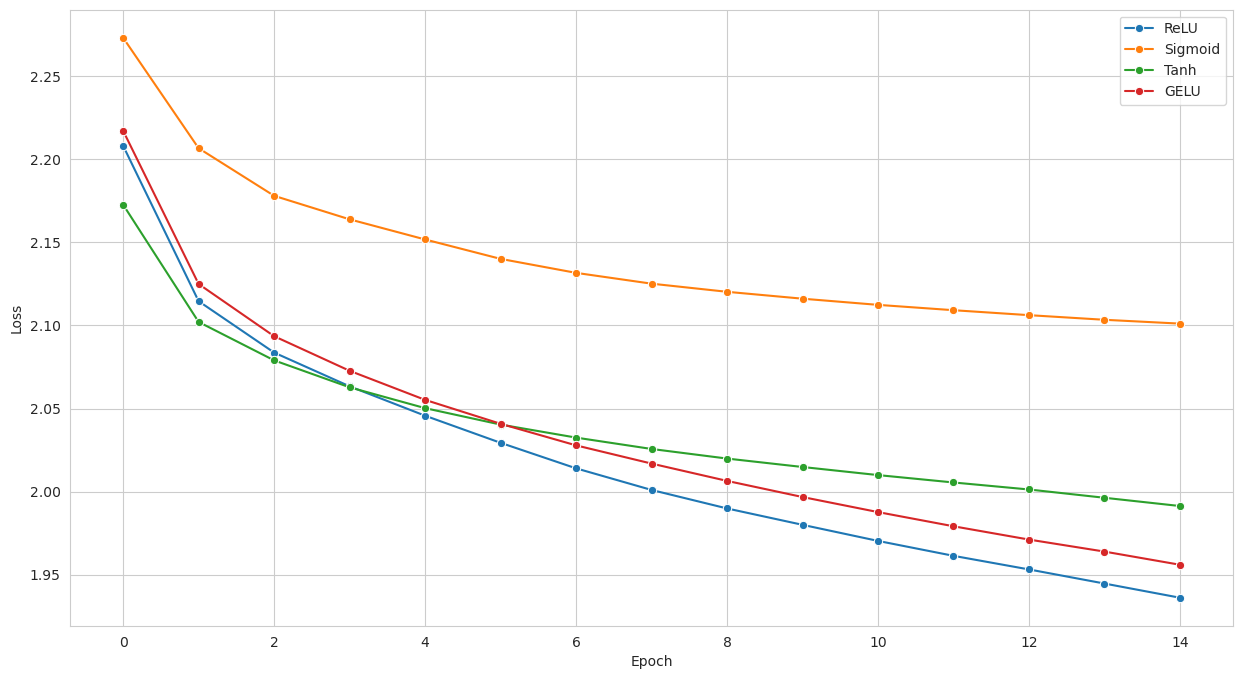

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

for k, (losses, test_loss, accuracy) in af_results.items():
    sns.lineplot(losses, label=k, ax=ax, marker='o')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.show()

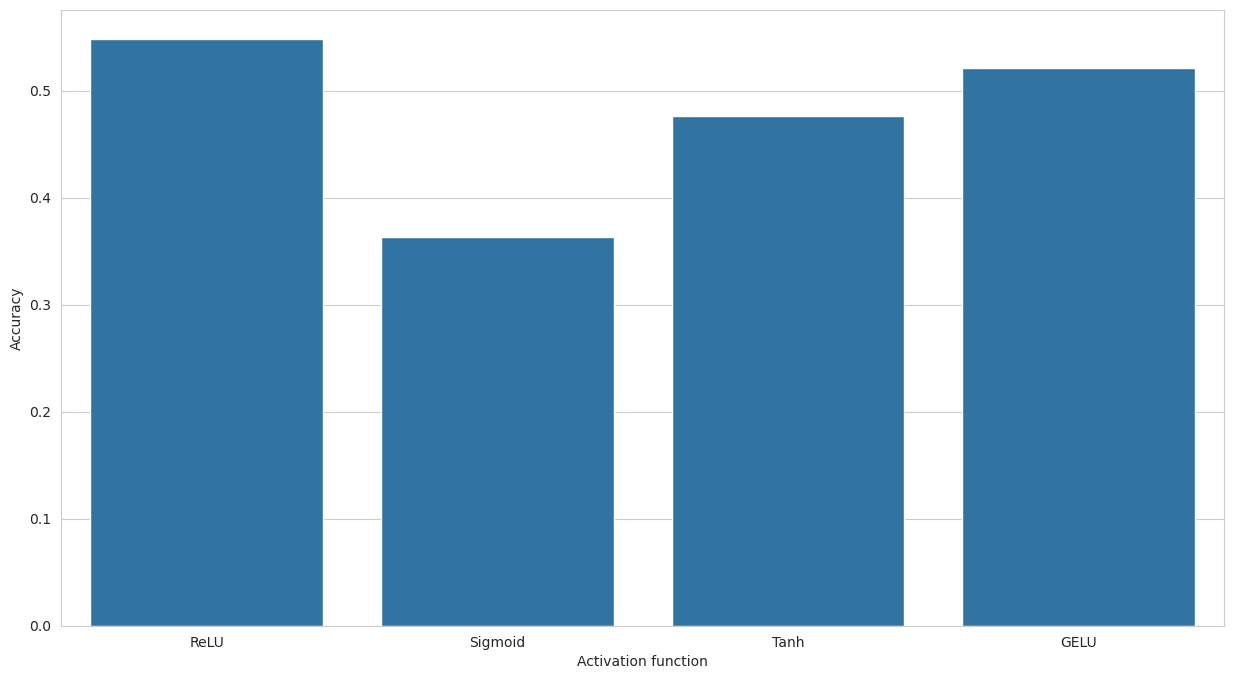

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

ks = []
vs = []

for k, (losses, test_loss, accuracy) in af_results.items():
    ks += [k]
    vs += [accuracy]
    
sns.barplot(x=ks, y=vs, ax=ax)

ax.set_xlabel("Activation function")
ax.set_ylabel("Accuracy")

plt.show()

### Hidden Layer tuning

In [31]:
hl_grid = {
    "hu_128": 128,
    "hu_256": 256,
    "hu_512": 512,
    "hu_1024": 1024,
    "hu_2048": 2048
}

hl_results = {}

for k, hu in hl_grid.items():
    model = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(32 * 32 * 3, hu),
        torch.nn.ReLU(),
        torch.nn.Linear(hu, 10),
        torch.nn.Softmax(dim=1)
    )
    losses = train_model(model, trainloader, epoch=15, lr=lambda epoch: 0.1 * (1/1+0.01*epoch))
    test_loss, accuracy = eval_model(model, testloader)
    hl_results[k] = (losses, test_loss, accuracy)

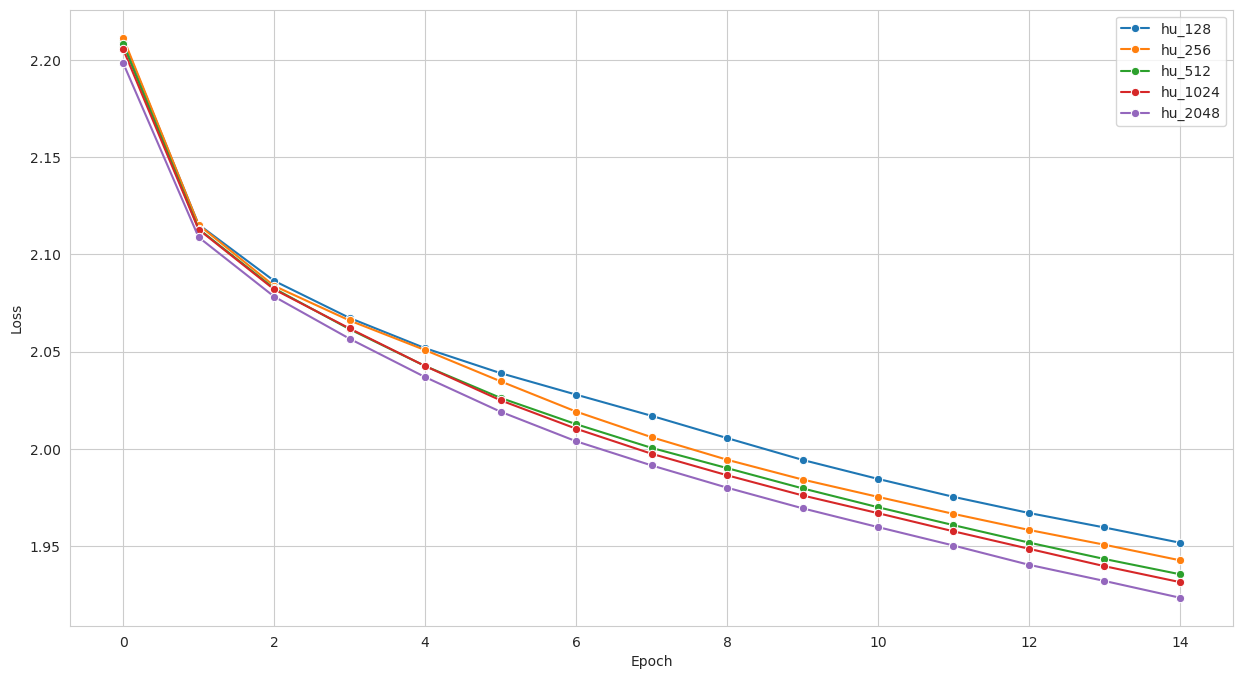

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

for k, (losses, test_loss, accuracy) in hl_results.items():
    sns.lineplot(losses, label=k, ax=ax, marker='o')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.show()

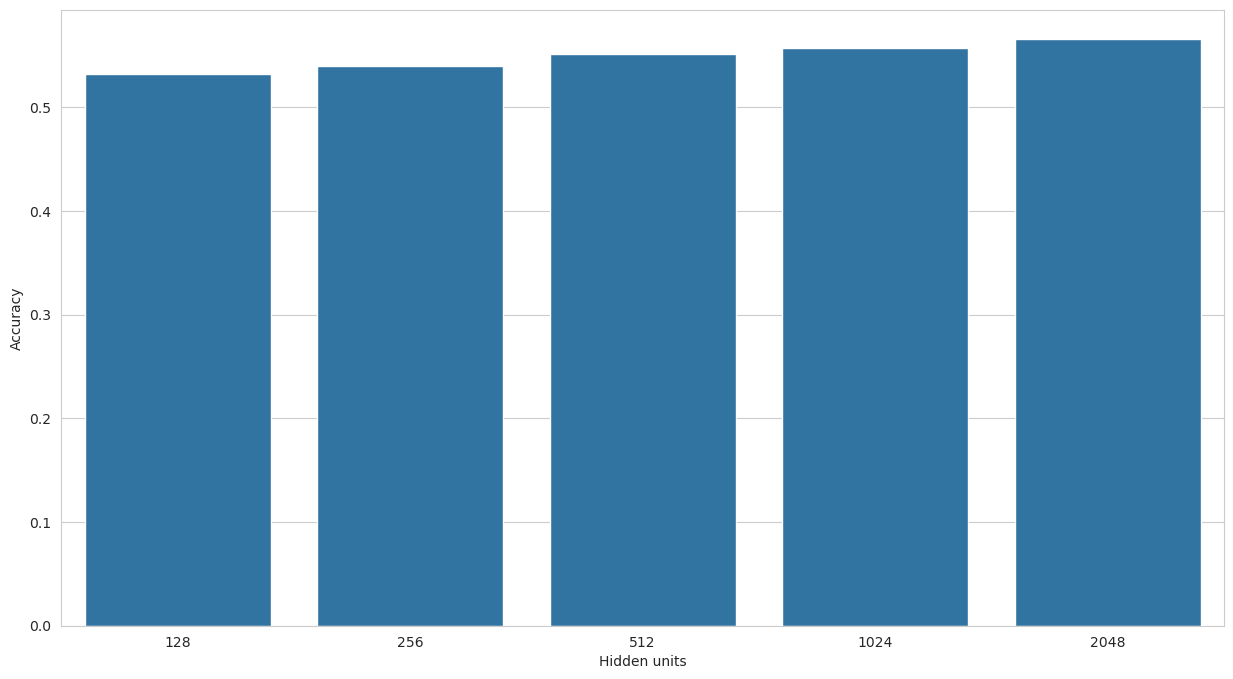

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

ks = []
vs = []

for k, (losses, test_loss, accuracy) in hl_results.items():
    ks += [k[3:]]
    vs += [accuracy]
    
sns.barplot(x=ks, y=vs, ax=ax)

ax.set_xlabel("Hidden units")
ax.set_ylabel("Accuracy")

plt.show()

In [34]:
dl_grid = {
    "hl_1": 1,
    "hl_2": 2,
    "hl_5": 5,
}

dl_results = {}

for k, dp in dl_grid.items():
    model = torch.nn.Sequential()
    model.append(torch.nn.Flatten())
    model.append(torch.nn.Linear(32 * 32 * 3, 256))
    model.append(torch.nn.ReLU())
    for _ in range(1, dp):
        model.append(torch.nn.Linear(256, 256))
        model.append(torch.nn.ReLU())
    model.append(torch.nn.Linear(256, 10))
    model.append(torch.nn.Softmax(dim=1))
    
    losses = train_model(model, trainloader, epoch=15, lr=lambda epoch: 0.1 * (1/1+0.01*epoch))
    test_loss, accuracy = eval_model(model, testloader)
    dl_results[k] = (losses, test_loss, accuracy)

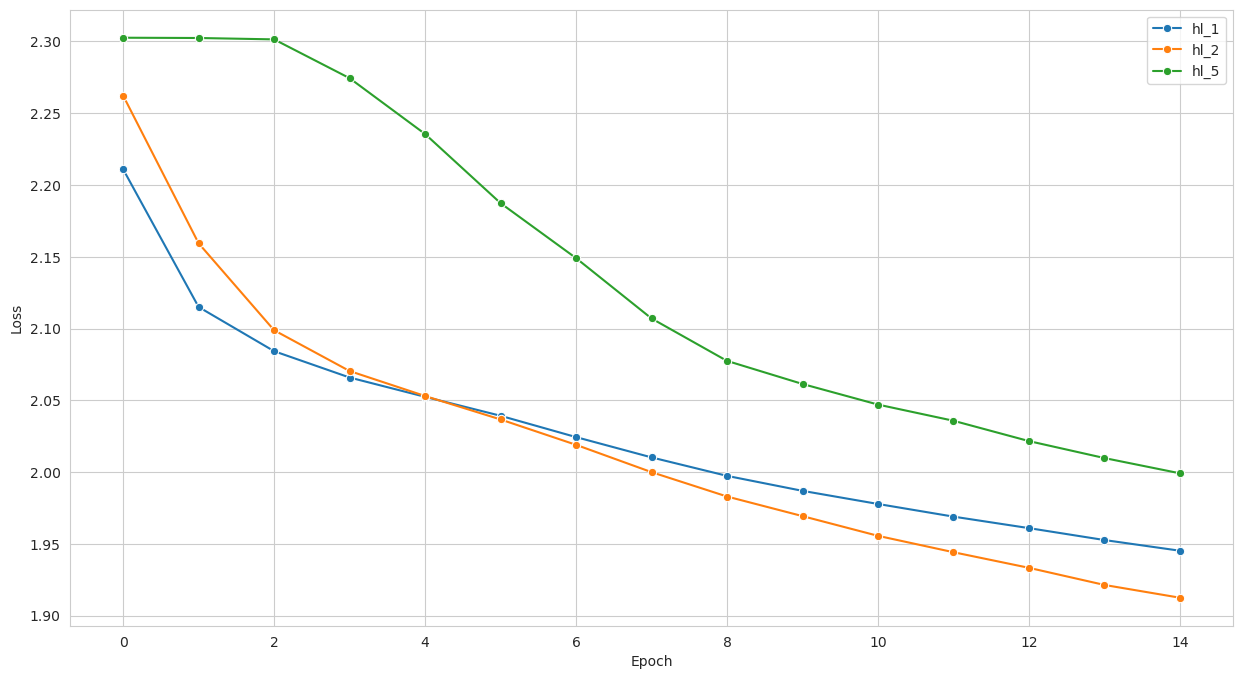

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

for k, (losses, test_loss, accuracy) in dl_results.items():
    sns.lineplot(losses, label=k, ax=ax, marker='o')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

plt.show()

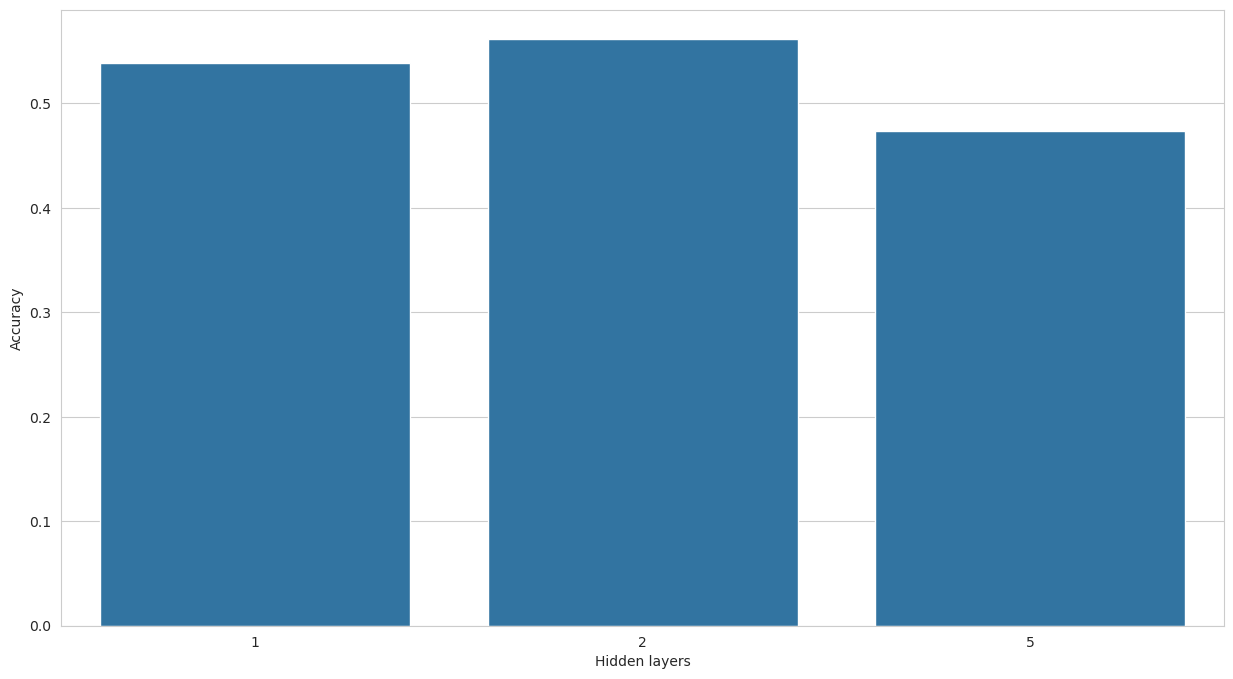

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

ks = []
vs = []

for k, (losses, test_loss, accuracy) in dl_results.items():
    ks += [k[3:]]
    vs += [accuracy]
    
sns.barplot(x=ks, y=vs, ax=ax)

ax.set_xlabel("Hidden layers")
ax.set_ylabel("Accuracy")

plt.show()

---